In [ ]:
# G/SG Morph - The Graph/Subgraph Isomorphism Library for Quantum Annealers.
# Copyright (C) 2021 If and Only If (Iff) Technologies

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Graph Node Benchmark

In this benchmark, Hua's implementation of the graph isomorphism QUBO in his thesis ["Adiabatic Quantum Computing with QUBO Formulations", Appendix E](https://researchspace.auckland.ac.nz/bitstream/handle/2292/31576/whole.pdf?sequence=2&isAllowed=y) is compared against the G/SG Morph implementation of the same QUBO with regards to the QUBO generation time given increasing larger graphs.

The graphs in question are Erdos-Renyi graphs with a fixed edge formation probability (0.5) but increasing number of nodes starting from 1 to 65. To ensure the given graphs are isomorphic, a technique is used from Calude, Dinneen, and Hua's paper ["QUBO formulations for the graph isomorphism problem and related problems"](https://doi.org/10.1016/j.tcs.2017.04.016), page 8 "A random permutation of the vertices of each graph G1 was generated to obtain G2, hence the graphs G1 and G2 are always isomorphic".

The results obtained in the `node_benchmarking_results.csv` file were from running a slightly modified copy of this notebook (which had a different file path and some additional statements to allow for Google Colab to see the gsgmorph library and access to a Google Drive account) on Google Colab.

Ideally, the test would have been extended to 100+ nodes to get an even better idea of performance scaling but at around 70 nodes Colab terminates the benchmarking due to excessive RAM usage.

In [ ]:
import networkx as nx
import numpy as np
import gsgmorph.matrix_form
import timeit
import matplotlib.pyplot as plt
import csv

In [ ]:
rng = np.random.default_rng()

with open('node_benchmark.csv', 'w', newline='') as csvfile:
    fieldnames = ['num_nodes', 'gsgmorph', 'hua', 'qubo_equal']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # go from 1 to 65 nodes, with 0.5 probability for edge formation
    for n in range(1, 66):
        g1 = nx.erdos_renyi_graph(n, 0.5, seed=0)


        print("Nodes: {0}".format(n))

        # Keep the edges the same but shuffle the nodes around, 
        # inspired by Calude, Dinneen, and Hua's paper
        # "QUBO formulations for the graph isomorphism problem and related problems"
        # https://doi.org/10.1016/j.tcs.2017.04.016
        perm = rng.permutation(g1.nodes())
        mapping = {i: v for i, v in zip(g1.nodes(), perm)}
        g2 = nx.relabel_nodes(g1, mapping, copy=True)
        
        def gsgm_graph_isomorphism():
            gsgmorph.matrix_form.integer_graph_isomorphism(g1,g2)
        def hua_graph_isomorphism():
            gsgmorph.matrix_form.hua_graph_isomorphism(g1,g2)
        # `timeit` arguments: https://stackoverflow.com/a/56763499
        # number: run the program back-to-back 
        # repeat: repeat * number (see line above)
        gsgmorph_time = min(timeit.repeat(gsgm_graph_isomorphism, repeat=2, number=4))
        hua_time = min(timeit.repeat(hua_graph_isomorphism, repeat=2, number=4))

        # Ensure the QUBO matrices obtained are equal
        gsgmorph_matrix = gsgmorph.matrix_form.integer_graph_isomorphism(g1, g2) 
        hua_matrix = gsgmorph.matrix_form.hua_graph_isomorphism(g1, g2)
        matrix_equal = ""
        
        if(gsgmorph_matrix == hua_matrix):
            matrix_equal = "TRUE"
        else:
            matrix_equal = "FALSE"
        writer.writerow({'num_nodes':n, 
                         'gsgmorph': gsgmorph_time,
                         'hua': hua_time,
                         'qubo_equal':matrix_equal})


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

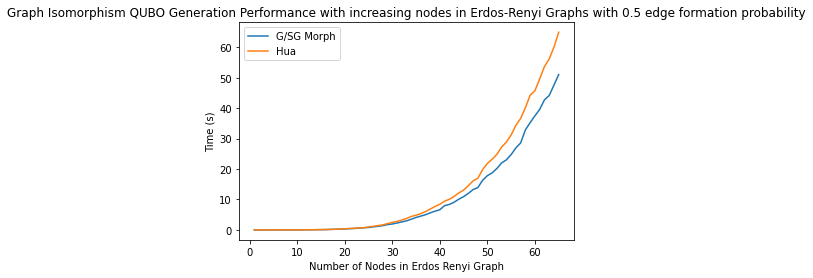

In [3]:
df = pd.read_csv("node_benchmarking_results.csv")

# Number of nodes
x = df['num_nodes']

# Results from G/SG Morph and Hua's implementation
gsgm = df['gsgmorph']
hua = df['hua']

plt.plot(x, gsgm, label='G/SG Morph') 
plt.plot(x, hua, label='Hua')
plt.xlabel('Number of Nodes in Erdos Renyi Graph')
plt.ylabel('Time (s)')
plt.title("Graph Isomorphism QUBO Generation Performance with increasing nodes in Erdos-Renyi Graphs with 0.5 edge formation probability")
plt.legend()
